In [5]:
import numpy as np
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [46]:
word2vec_model_path = "GoogleNews-vectors-negative300.bin"  # Path to the Word2Vec model file
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)

In [6]:
df = pd.read_csv("buisness_data.csv")
print(df.shape)

(172, 5)


In [8]:
def recommend_categ_for_prompt(prompt, df, word2vec_model):
    prompt_tokens = prompt.lower().split()

    # Calculate average vector representation of the prompt
    prompt_vector = np.mean([word2vec_model[token] for token in prompt_tokens if token in word2vec_model], axis=0)

    # Calculate similarity between the prompt and each business category
    similarities = {}
    for category in df['Category']:
        category_tokens = category.lower().split()
        category_vector = np.mean([word2vec_model[token] for token in category_tokens if token in word2vec_model], axis=0)
        if category_vector is not None and not np.isnan(category_vector).any():
            similarities[category] = cosine_similarity([prompt_vector], [category_vector])[0][0]

    # Get the most similar business category
    if similarities:  # Check if similarities dictionary is not empty
        most_similar_category = max(similarities, key=similarities.get)
        recommended_investors = df[df['Category'] == most_similar_category]['Investors'].values[0]
        return [most_similar_category, recommended_investors]
    else:
        return ["No similar category found", "No recommended investors"]

In [11]:
from sklearn.preprocessing import LabelEncoder

categories = df['Category'].unique()
category_encoded = pd.get_dummies(df['Category'], prefix='Category')
business_size_encoded = pd.get_dummies(df['Business Size'], prefix='Business')
location_encoded = pd.get_dummies(df['Location'], prefix='Location')

# Concatenate the one-hot encoded columns with the original DataFrame
df_encoded = pd.concat([df, category_encoded, business_size_encoded, location_encoded], axis=1)

# Drop the original columns
df_encoded.drop(columns=['Category', 'Business Size', 'Location'], inplace=True)


label_encoder = LabelEncoder()
label_encoder.fit(df_encoded['Investors'])
y_train_encoded = label_encoder.transform(df_encoded['Investors'])

X = df_encoded.drop(['User Name', 'Investors'], axis=1)

# Example usage:
prompt = "I want to start a car business"
# result = recommend_categ_for_prompt(prompt, df, word2vec_model)
# print("Most similar category:", result[0])
# print("Recommended investors:", result[1])
print(y_train_encoded.shape)
print(X.shape)

(172,)
(172, 48)


In [14]:
X_train, X_val, y_train_encoded2, y_val_encoded = train_test_split(X, y_train_encoded, test_size=0.2, random_state=42)
print("Shape of X:", X.shape)
print("Shape of y_encoded:", y_train_encoded2.shape)

Shape of X: (172, 48)
Shape of y_encoded: (137,)


(137,)
Training Accuracy: 1.0
Validation Accuracy: 0.8285714285714286


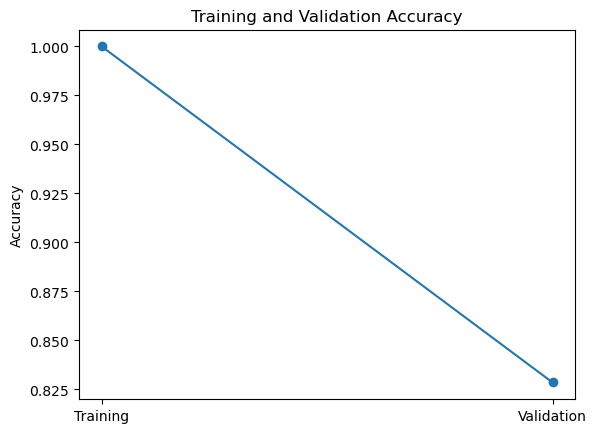

D:\Programs\Anaconda\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


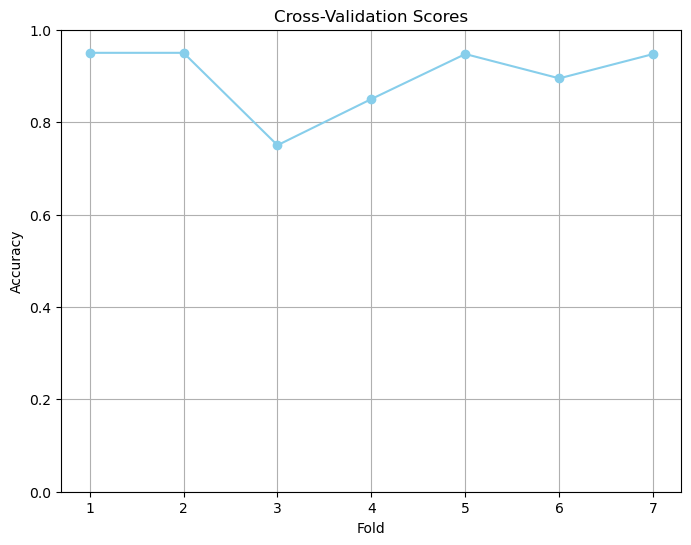

In [88]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

print(y_train_encoded2.shape)

# Create an SVC model
svc_model = SVC(kernel='linear')

# Train the model
svc_model.fit(X_train, y_train_encoded2)

# Predictions
train_preds = svc_model.predict(X_train)
val_preds = svc_model.predict(X_val)

# Compute accuracy
train_accuracy = accuracy_score(y_train_encoded2, train_preds)
val_accuracy = accuracy_score(y_val_encoded, val_preds)

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")

# Plotting the accuracy graph
plt.plot([1, 2], [train_accuracy, val_accuracy], marker='o')
plt.xticks([1, 2], ['Training', 'Validation'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.show()


cv_scores = cross_val_score(svc_model, X_train, y_train_encoded2, cv=7)  # 5-fold cross-validation

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', color='skyblue', linestyle='-')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores')
plt.ylim(0, 1)  # Limit y-axis to between 0 and 1 for accuracy
plt.grid(True)  # Add gridlines for better readability
plt.show()

In [94]:
def predict_svc(prompt,loc,size):
    df = pd.read_csv("buisness_data.csv")

    label_encoder = LabelEncoder()
    label_encoder.fit(df['Investors'])
    y_train_encoded = label_encoder.transform(df['Investors'])
    categ = recommend_categ_for_prompt(prompt,df,word2vec_model)[0]
    # Assuming data is your new data represented as a dictionary
    data = {
        "Category": categ,  # Replace 'New Category' with the category of your new data
        "Location": loc,  # Replace 'New Location' with the location of your new data
        "Business": size  # Replace 'New Size' with the business size of your new data
    }

    # Create a DataFrame from the new data
    new_df = pd.DataFrame(data, index=[0])  # Creating a DataFrame with a single row

    # Concatenate the original DataFrame with the new DataFrame
    combined_df = pd.concat([df, new_df], ignore_index=True)
    # One-hot encode the combined DataFrame
    combined_df_encoded = pd.get_dummies(combined_df, columns=['Category', 'Business Size', 'Location'], prefix=['Category','Business','Location'])

    # Extract the last row (the new data) from the combined one-hot encoded DataFrame
    new_data_encoded = combined_df_encoded.iloc[[-1]]
    new_data_encoded.drop(columns = ["User Name","Investors","Business"], inplace=True)

    predictions = svc_model.predict(new_data_encoded)
    predicted_labels = label_encoder.inverse_transform(predictions)
    print(predicted_labels)


predict_svc("i want to start a cookie buisness", "Delhi" , "Small")

['BakeInvest, Pastry Partners']


D:\Programs\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\Anaconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\Programs\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\Anaconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\Programs\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\Anaconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\Programs\Anaconda\Lib\site-pack

D:\Programs\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


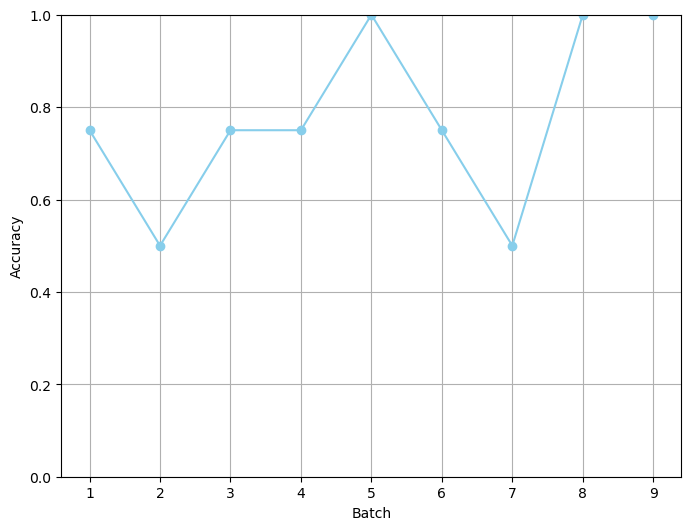

Overall Accuracy: 0.7714285714285715
Overall Precision: 0.7714285714285714
Overall Recall: 0.77
Overall F1-Score: 0.7587301587301587


In [33]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_train, y_train_encoded2, X_val, and y_val_encoded are defined

# Create an SVC model
svc_model = SVC(kernel='linear')

# Train the model
svc_model.fit(X_train, y_train_encoded2)

# Define batch size
batch_size = 4

# Compute number of batches
num_batches = len(X_val) // batch_size + 1

# List to store accuracy for each batch
batch_accuracies = []

# Lists to store predictions and true labels for computing overall metrics
val_preds_all = []
y_val_all = []

# Iterate over batches
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(X_val))
    X_val_batch = X_val[start_idx:end_idx]
    y_val_batch = y_val_encoded[start_idx:end_idx]
    
    # Predictions
    val_preds = svc_model.predict(X_val_batch)
    val_preds_all.extend(val_preds)
    y_val_all.extend(y_val_batch)
    
    # Compute accuracy for the batch
    batch_accuracy = accuracy_score(y_val_batch, val_preds)
    batch_accuracies.append(batch_accuracy)

# Compute overall metrics
overall_accuracy = accuracy_score(y_val_all, val_preds_all)
precision = precision_score(y_val_all, val_preds_all, average='macro')
recall = recall_score(y_val_all, val_preds_all, average='macro')
f1 = f1_score(y_val_all, val_preds_all, average='macro')

# Plotting the accuracy for each batch
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_batches + 1), batch_accuracies, marker='o', color='skyblue', linestyle='-')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Print overall metrics
print("Overall Accuracy:", overall_accuracy)
print("Overall Precision:", precision)
print("Overall Recall:", recall)
print("Overall F1-Score:", f1)
